In [2]:
!pip install datasets sklearn_crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and p

# Load dataset

In [3]:
from datasets import load_dataset
dataset = load_dataset("eriktks/conll2003")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for eriktks/conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/eriktks/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [5]:
dataset["train"][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [6]:
ner_feature = dataset['train'].features['ner_tags']
label_list = ner_feature.feature.names

In [7]:
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

# Trích xuất đặc trưng

In [8]:
def word2features(tokens, pos_tags, i):
    word = tokens[i]
    postag = pos_tags[i]

    if not word or not postag:
        word = "<UNK>"
        postag = "<UNK>"

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'postag': postag,
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = tokens[i - 1]
        postag1 = pos_tags[i - 1]
        if not word1 or not postag1:
            word1 = "<UNK>"
            postag1 = "<UNK>"
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:postag': postag1,
        })
    else:
        features['BOS'] = True

    if i < len(tokens) - 1:
        word1 = tokens[i + 1]
        postag1 = pos_tags[i + 1]
        if not word1 or not postag1:
            word1 = "<UNK>"
            postag1 = "<UNK>"
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:postag': postag1,
        })
    else:
        features['EOS'] = True
    return features

def sent2features(example):
    return [word2features(example["tokens"], example["pos_tags"], i) for i in range(len(example["tokens"]))]

def sent2labels(example):
    return [label_list[i] for i in example["ner_tags"]]


# Chia tập train/test

In [9]:
X_train = [sent2features(example) for example in dataset['train']]
y_train = [sent2labels(example) for example in dataset['train']]

X_test = [sent2features(example) for example in dataset['test']]
y_test = [sent2labels(example) for example in dataset['test']]

# Huấn luyện mô hình

In [10]:
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn.model_selection import GridSearchCV

crf = CRF(
    algorithm = 'lbfgs',
    max_iterations=100,
    all_possible_transitions=True,
)

params_space = {
    'c1': [0.01, 0.05, 0.1, 0.5, 1.0],
    'c2': [0.01, 0.05, 0.1, 0.5, 1.0]
}

In [11]:
f1_scorer = scorers.make_scorer(metrics.flat_f1_score, average='weighted', labels=label_list[1:])

gs = GridSearchCV(
    crf,
    params_space,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring=f1_scorer
)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3,
             estimator=CRF(algorithm='lbfgs', all_possible_transitions=True,
                           max_iterations=100),
             n_jobs=-1,
             param_grid={'c1': [0.01, 0.05, 0.1, 0.5, 1.0],
                         'c2': [0.01, 0.05, 0.1, 0.5, 1.0]},
             scoring=make_scorer(flat_f1_score, response_method='predict', average=weighted, labels=['B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']),
             verbose=1)

In [18]:
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)

# Lấy mô hình tốt nhất
crf_best = gs.best_estimator_

Best params: {'c1': 0.01, 'c2': 0.01}
Best CV score: 0.8476156526548273


# Dự đoán trên tập test

In [21]:
y_pred_test = crf_best.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred_test, labels=label_list[1:], digits=3))

              precision    recall  f1-score   support

       B-PER      0.850     0.846     0.848      1617
       I-PER      0.882     0.953     0.916      1156
       B-ORG      0.802     0.696     0.745      1661
       I-ORG      0.672     0.760     0.713       835
       B-LOC      0.855     0.854     0.854      1668
       I-LOC      0.784     0.763     0.773       257
      B-MISC      0.822     0.758     0.789       702
      I-MISC      0.680     0.630     0.654       216

   micro avg      0.818     0.807     0.813      8112
   macro avg      0.793     0.782     0.787      8112
weighted avg      0.818     0.807     0.812      8112



In [43]:
sample_idx = 5
sample_features = X_test[sample_idx]
sample_tokens = dataset["test"][sample_idx]["tokens"]
true_labels = y_test[sample_idx]

In [44]:
predicted_labels = crf_best.predict([sample_features])[0]

In [45]:
print(f"{'Token':15} {'True':10} {'Predicted'}")
print("-" * 40)
for token, true, pred in zip(sample_tokens, true_labels, predicted_labels):
    print(f"{token:15} {true:10} {pred}")

Token           True       Predicted
----------------------------------------
China           B-LOC      B-LOC
controlled      O          O
most            O          O
of              O          O
the             O          O
match           O          O
and             O          O
saw             O          O
several         O          O
chances         O          O
missed          O          O
until           O          O
the             O          O
78th            O          O
minute          O          O
when            O          O
Uzbek           B-MISC     B-PER
striker         O          O
Igor            B-PER      B-PER
Shkvyrin        I-PER      I-PER
took            O          O
advantage       O          O
of              O          O
a               O          O
misdirected     O          O
defensive       O          O
header          O          O
to              O          O
lob             O          O
the             O          O
ball            O          O
over   

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

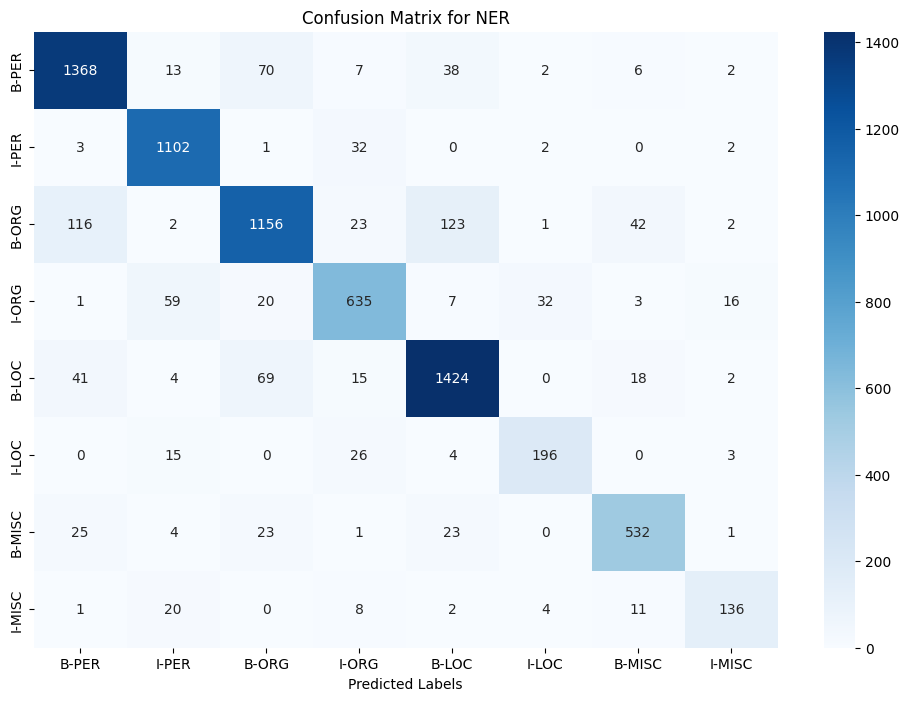

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Flatten the lists of true labels and predicted labels, keeping track of indices
y_true_flat = []
y_pred_flat = []
for i, sent in enumerate(y_test):
    for j, label in enumerate(sent):
        if label != "O":
            y_true_flat.append(label)
            # Ensure that the corresponding prediction is also added, even if it's "O"
            y_pred_flat.append(y_pred_test[i][j])

# Tính confusion matrix
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=label_list[1:])

# Vẽ confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=label_list[1:], yticklabels=label_list[1:])
plt.title("Confusion Matrix for NER")
plt.xlabel("Predicted Labels")
plt